In [0]:
import tensorflow as tf
# from audioset import vggish_input
# from audioset import vggish_slim
# from audioset import vggish_postprocess
# from audioset import vggish_params
# from audioset import mel_features

import numpy as np
from scipy.io import wavfile
# import resampy
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

# Defining the CNN
We are loading the pretrained VGGish model from the audioset directory. The original repo can be found [here](https://github.com/tensorflow/models/tree/master/research/audioset).

In [0]:
plt.rcParams['figure.figsize'] = 15, 8

PCA_PARAMS = 'audioset/vggish_pca_params.npz'
CHECKPOINT = 'audioset/vggish_model.ckpt'
OUTPUT_FILE = 'output.h5'
wav_files = glob('../Data/*.wav')

In [6]:
glob('../Data/UrbanSound8k/audio/fold*/*-0-*-*.wav')

[]

In [0]:
# Prepare a postprocessor to munge the model embeddings
pproc = vggish_postprocess.Postprocessor(PCA_PARAMS)

tf.Graph().as_default()
sess = tf.Session()

# Define the model in inference mode, load the checkpoint, and
# locate input and output tensors.
vggish_slim.define_vggish_slim(training=False)
vggish_slim.load_vggish_slim_checkpoint(sess, CHECKPOINT)
features_tensor = sess.graph.get_tensor_by_name(vggish_params.INPUT_TENSOR_NAME)
embedding_tensor = sess.graph.get_tensor_by_name(vggish_params.OUTPUT_TENSOR_NAME)

INFO:tensorflow:Restoring parameters from audioset/vggish_model.ckpt


# What the input looks like
This isn't necessary for the processing, but it gives an idea of what the input to the model is. The first plot is the raw audio. This is what's fed to the speakers. The second plot is the log mel spectrogram. This is more or less what humans hear. 

The spectrogram is calculated by splitting the audio up into small chunks where we assume that the frequency content is essentially unchanging. We then calculate a Fast Fourier Transform over that chunk to get the frequency content. This gives us the frequency content in Hertz, however human hearing isn't exactly proportional to Hz so some psychologist developed the mel frequency scale to better capture how humans hear sound. That is the scale that we're using.

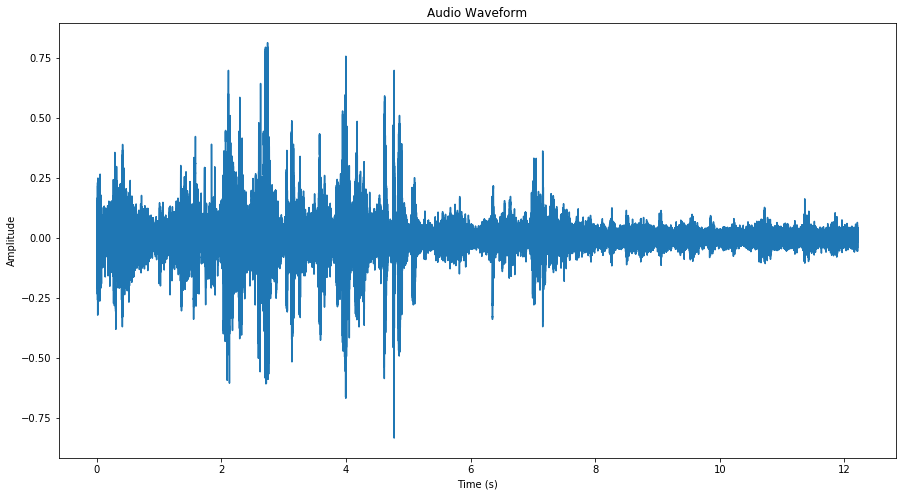

In [0]:
sr, audio_pcm = wavfile.read(wav_files[2])
# convert to mono, float, and resample to be 16k which is what vggish expects
audio_pcm = resampy.resample(audio_pcm.sum(axis=1) / 32768.0, sr, vggish_params.SAMPLE_RATE)
plt.plot(np.arange(0, len(audio_pcm)) / float(sr), audio_pcm)
plt.title('Audio Waveform')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude');

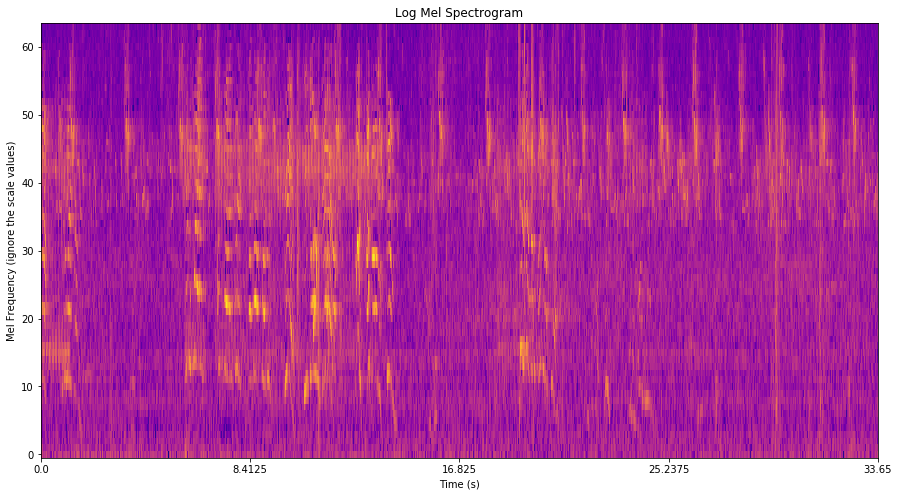

In [0]:
log_mel = mel_features.log_mel_spectrogram(audio_pcm,
      audio_sample_rate=vggish_params.SAMPLE_RATE,
      log_offset=vggish_params.LOG_OFFSET,
      window_length_secs=vggish_params.STFT_WINDOW_LENGTH_SECONDS,
      hop_length_secs=vggish_params.STFT_HOP_LENGTH_SECONDS,
      num_mel_bins=vggish_params.NUM_MEL_BINS,
      lower_edge_hertz=vggish_params.MEL_MIN_HZ,
      upper_edge_hertz=vggish_params.MEL_MAX_HZ)
plt.imshow(log_mel.T, cmap='plasma', aspect='auto', origin='lower')
plt.title('Log Mel Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Mel Frequency (ignore the scale values)')
xticks = np.linspace(0, log_mel.shape[0], 5)
plt.xticks(xticks, xticks * vggish_params.STFT_HOP_LENGTH_SECONDS);

# Run the model and get embeddings
The embeddings are extracted and then the PCA is taken of the embeddings.

In [0]:
# get the log mel spectrograms for each clip
examples = [
    vggish_input.wavfile_to_examples(wav_file)
    for wav_file in wav_files
]

In [0]:
# get the embeddings for each clip, size: [number_of_windows, 128]
embedding_batch = [
    sess.run([embedding_tensor], feed_dict={features_tensor: ex})[0]
    for ex in examples
]

# take the PCA of the embeddings for each clip
postprocessed_batch = [pproc.postprocess(emb) for emb in embedding_batch]

# Drawing the embeddings
This isn't really meaningful, but I was curious if there would be any visible patterns in the embeddings (I'm not really seeing any). The embeddings are 128 long feature vectors. I reshaped them to be 2D so that they would be easier to visualize. This is what we will be feeding into our neural network/svm/whatever.

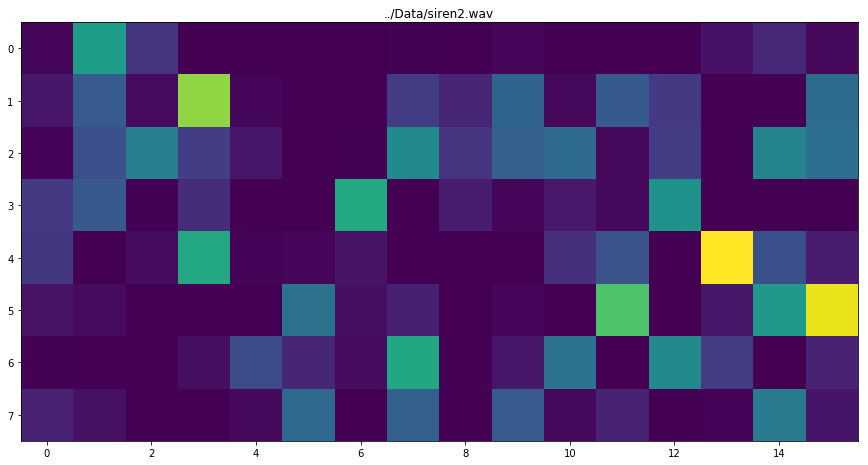

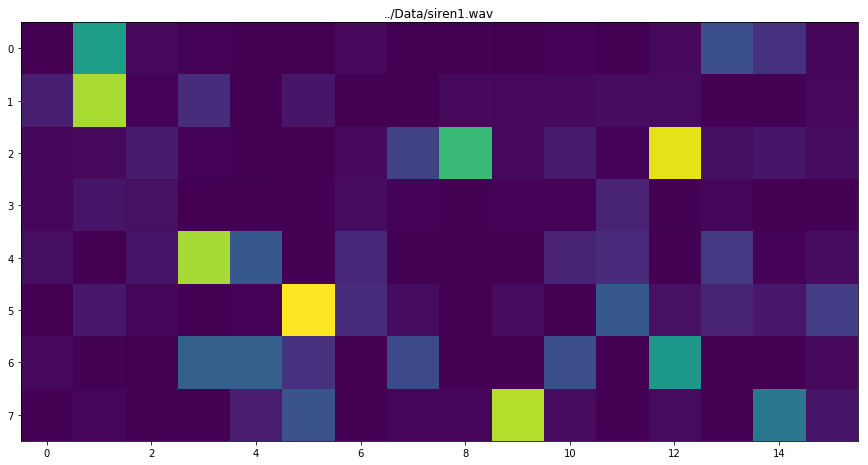

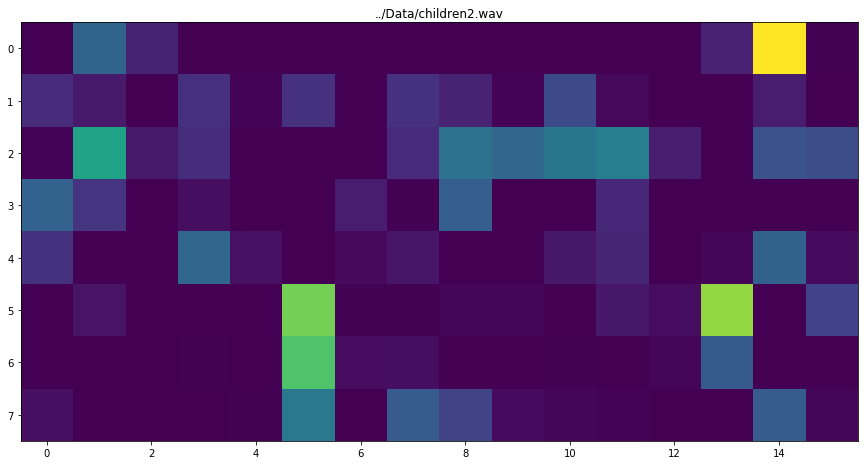

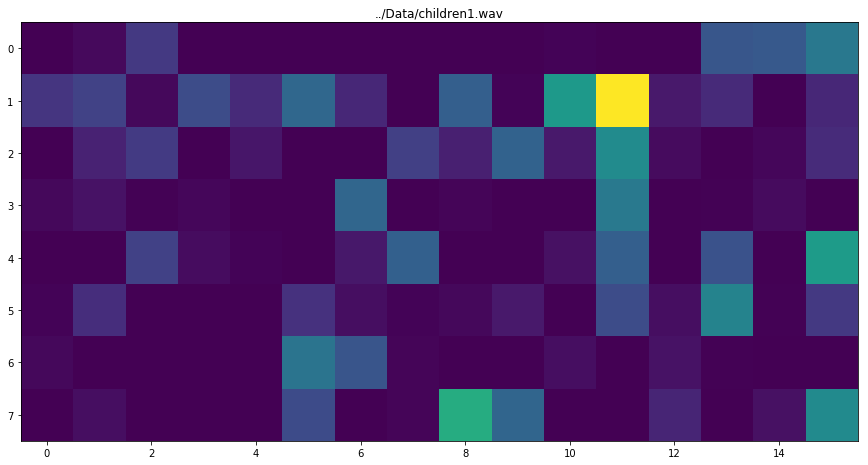

In [0]:
for f, emb in zip(wav_files, embedding_batch):
    plt.figure()
    plt.imshow(emb.mean(axis=0).reshape(8, -1))
    plt.title(f)